Spatial Correlation between sea surface temperature anomaly and sea surface height anomaly
===========================
#### Author: Jinbo Wang <Jinbo.Wang@jpl.nasa.gov>
#### Date: 12/13/2021
#### Modified by: Dean Henze <dean.c.henze@jpl.nasa.gov> (10/26/2023)

***Any functions below which are duplicated from Jinbo's originals have been modified .***

This notebook centers around the `spatial_corrmap()` fxn, which will create a 2D lat, lon map of spatial correlations between sea surface height (SSH) and sea surface temperature (SST), both hosted on PO.DAAC. The SSH dataset is shortname SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812 and the SST dataset is shortname MW_OI-REMSS-L4-GLOB-v5.0.

At each gridpoint, the spatial correlation is computed over a lat, lon window of size 2*lat_halfwin x 2*lon_halfwin. This is done for each gridpoint in the datasets. Spatial correlation is computed from the SSH, SST anomalies, which are computed in turn as the deviations from a fitted 2D surface over the window (a new 2D surface is fitted for each window around each gridpoint).

#### Current Status
Code is in a state where the spatial_corrmap() function can be tested with Coiled functions. The current estimated time for running spatial_corrmap() on a single SSH-SST file-pair at full resolution is ~1 hour. Currently working to reduce this time.

In [3]:
from matplotlib import pylab as plt
import xarray as xr
import numpy as np
from numpy import zeros,arange
from scipy.optimize import leastsq
import numpy as np
import requests, s3fs
import boto3
import sys

# Define functions

In [4]:
def init_S3FileSystem():
    """
    Returns an S3FileSystem object equiped with temporary credentials (1 hour), 
    used to access / open files from an S3 bucket. 

    !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    THIS REQUIRES A .NETRC FILE ON THE HOME DIRECTORY
    !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    Input the following into a temporary code block in this notebook (replacing 
    <username> and <password> with your Earthdata login info):
    !touch ~/.netrc
    !echo "machine urs.earthdata.nasa.gov" > ~/.netrc
    !echo "    login <username>" >> ~/.netrc
    !echo "    password <password>" >> ~/.netrc
    
    Returns
    -------
    s3: S3FileSystem object
        Used to access / open files from an S3 bucket.

    Import requirements
    -------------------
    requests, s3fs
    """
    s3_cred_endpoint = {
        'podaac':'https://archive.podaac.earthdata.nasa.gov/s3credentials',
        'lpdaac':'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials'}

    temp_creds_url = s3_cred_endpoint['podaac']
    creds = requests.get(temp_creds_url).json()
    s3 = s3fs.S3FileSystem(anon=False,
                           key=creds['accessKeyId'],
                           secret=creds['secretAccessKey'], 
                           token=creds['sessionToken'])
    return s3

In [5]:
def load_sst_ssh(s3sys, ssh_fn):
    """
    Return datasets for a single file each of sea surface height (SSH) and sea surface temperature (SST)
    as Xarray.Dataset's. The SSH dataset is shortname SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812 
    and the SST dataset is shortname MW_OI-REMSS-L4-GLOB-v5.0. This function takes in the S3 file path for
    the SSH, then returns the SSH file along with the SST file with timestamp on noon UTC of the same 
    day as the SSH file.
    
    Inputs
    ------
    s3sys: s3fs.S3FileSystem object
        Has crendential to access Earthdata S3 buckets
    ssh_fn: str
        Filename of SSH file in S3 location.

    Returns
    -------
    ssh, sst: xarray.DataArray's
        SSH and SST data (for 1 timestamp each), where the SST file loaded is 
        from noon UTC on the same day as that of the data from ssh_fn.
    """    
    # Get SLA variable from file:
    ssh=xr.open_dataset(s3sys.open(ssh_fn))['SLA'][0,...].T # The way the data are stored, they need to be transposed.

    # Get SST variable from SST file on same day as ssh_fn and at noon:
    date=ssh_fn.split('_')[-1][:8]
    sst_fn='podaac-ops-cumulus-protected/MW_OI-REMSS-L4-GLOB-v5.0/%s120000-REMSS-L4_GHRSST-SSTfnd-MW_OI-GLOB-v02.0-fv05.0.nc'%date
    sst=xr.open_dataset(s3sys.open(sst_fn))['analysed_sst'][0,...]
    
    return ssh, sst

In [14]:
def anomaly(lon, lat, p):
    """
    Get anomalies for a variable over a 2D map. Done by fitting a 2D surface 
    to the data and taking the anomaly as the difference between each data point 
    and the surface. 
    
    This is mostly a wrapper for fit2Dsurf() which does the anomaly calculation. 
    This wrapper could be extended e.g. to take inputs with various shapes and 
    reformat them to work with fit2Dsurf(), but curretly has basic functionality.

    Inputs
    ------
    lon, lat: 1D array-like
        Longitude and latitude arrays, or more generally, the x, y coordinates (don't 
        need to have units of degrees e.g.).
    p: 2D array-like
        Variable to get anomalies for. Should have same shape as (lat, lon). 

    Returns
    -------
    va, vm: 2D NumPy arrays
        Anomalies (va) and mean surface fit (vm).

    Import requirements
    -------------------
    numpy    
    """
    x1, y1 = np.meshgrid(lon, lat)
    va, vm = fit2Dsurf(x1, y1, p)
    return va,vm


def fit2Dsurf(x, y, p, kind='linear'):
    """
    Get anomalies for a variable over a 2D map. Done by fitting a 2D surface 
    to the data and taking the anomaly as the difference between each data point 
    and the surface. Surface can either be a linear or quadratic function.
    
    Inputs
    ------
    x, y, p: 2D array-like, all same size.
        Variables to use to fit the function p(x, y). x, y are the dependent vars
        and p is the dependent var.
    kind: str
        (Default = 'linear'). Either 'linear' or 'quadratic' to specify the 
        functional form of the fit surface.
    
    Returns
    ------
    va, vm: 2D NumPy arrays
        Anomalies (va) and mean surface fit (vm).

    Import requirements
    -------------------
    from scipy.optimize import leastsq
    numpy
    """
    # Depending on fit fxn chosen, define functions to output a 2D surface (surface()) 
    # and the difference between 2D data and the computed surface (err()). Each 
    # fxn takes independent vars and polynomial coefficients; the err() fxn's in 
    # addition take data for the dependent var.
    if kind=='linear':
        def err(c,x0,y0,p):
            a,b,c=c
            return p - (a + b*x0 + c*y0 )

        def surface(c,x0,y0):
            a,b,c=c
            return a + b*x0 + c*y0

    if kind=='quadratic':
        def err(c,x0,y0,p):
            a,b,c,d,e,f=c
            return p - (a + b*x0 + c*y0 + d*x0**2 + e*y0**2 + f*x0*y0)
        
        def surface(c,x0,y0):
            a,b,c,d,e,f=c
            return a + b*x0 + c*y0 + d*x0**2 + e*y0**2 + f*x0*y0


    # Prep arrays and remove NAN's:
    xf=x.flatten()
    yf=y.flatten()
    pf=p.flatten()

    msk=~np.isnan(pf)
    pf=pf[msk]
    xf=xf[msk]
    yf=yf[msk]

    
    # Initial values of polynomial coefficients to start fitting algorithm off with:
    dpdx=(pf.max()-pf.min())/(xf.max()-xf.min())
    dpdy=(pf.max()-pf.min())/(yf.max()-yf.min())
    if kind=='linear':
        c = [pf.mean(),dpdx,dpdy]
    if kind=='quadratic':
        c = [pf.mean(),dpdx,dpdy,1e-22,1e-22,1e-22]


    # Fit:
    coef = leastsq(err,c,args=(xf,yf,pf))[0]
    vm = surface(coef,x,y) #mean surface
    va = p - vm #anomaly
    return va,vm

In [43]:
def spatial_corrmap(ssh_fn, lat_halfwin, lon_halfwin, lats=None, lons=None, f_notnull=0.5, s3sys=None):
    """
    Get a 2D map of SSH-SST spatial correlation coefficients. The SSH dataset is 
    shortname SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812 
    and the SST dataset is shortname MW_OI-REMSS-L4-GLOB-v5.0. 

    At each gridpoint, the spatial correlation is computed over a lat, lon window
    of size 2*lat_halfwin x 2*lon_halfwin. This is done for each gridpoint in
    the datasets. Spatial correlation is computed from the SSH, SST anomalies, 
    which are computed in turn as the deviations from a fitted 2D surface over 
    the window (a new 2D surface is fitted for each window around each gridpoint).
    
    Inputs
    ------
    ssh_fn: str
        Filename of SSH file in S3 location.  
    lat_halfwin, lon_halfwin: floats
        Half window size in degrees for latitude and longitude dimensions, respectively.
    lats, lons: None or 1D array-like
        These make up the latitude, longitude grid on which to compute correlations. 
        If None, will default to using the grid of the SSH product. Note that regardless
        of the lats, lons passed to this function, it will still use the gridpoints 
        of the SSH product for the actual computations.
    f_notnull: float (default = 50)
        Fraction of elements in a window that have to be non-nan. Percentage is computed
        as number of null elements divided by total number expected to be in the window. So
        for edge cases, 'ghost' elements at the edges are considered nan.
    s3sys: s3fs.S3FileSystem object
        Has crendential to access Earthdata S3 buckets. If None (default), then a
        new S3FileSystem object is created and used.

    Returns
    ------
    coef: 2D numpy array
        Spatial correlation coefficients.
    
    lats, lons: 1D numpy arrays.
        Latitudes and longitudes creating the 2D grid that 'coef' was calculated on.
    """    
    # Load datafiles, convert SST lon to (0,360) bounds, and interpolate SST to SSH grid:
    if s3sys is None:
        s3sys=init_S3FileSystem()
    ssh,sst=load_sst_ssh(s3sys, ssh_fn)
    sst=sst.roll(lon=len(sst['lon'])//2)
    sst['lon']=sst['lon']+180
    sst=sst.interp(lon=ssh['Longitude']).interp(lat=ssh['Latitude'])

    
    # Compute windows size and threshold number of non-nan points:
    dlat = (ssh['Latitude'][1]-ssh['Latitude'][0]).item()
    dlon = (ssh['Longitude'][1]-ssh['Longitude'][0]).item()
    nx_win = 2*round(lon_halfwin/dlon)
    ny_win = 2*round(lat_halfwin/dlat)
    n_thresh = nx_win*ny_win*f_notnull


    # Map of booleans for sst*ssh==np.nan. Will be used to determine if there are 
    # enough non-nan values to compute the correlation for a given window:
    notnul = (sst*ssh).notnull()

    
    # Compute spatial correlations over whole map:
    coef = []
    
    if lats is None:
        lats = ssh['Latitude'].data
        lons = ssh['Longitude'].data
    
    for lat_cen in lats:
        for lon_cen in lons:

            # Create window for both sst and ssh with xr.sel:
            lat_bottom = lat_cen - lat_halfwin
            lat_top = lat_cen + lat_halfwin
            lon_left = lon_cen - lon_halfwin
            lon_right = lon_cen + lon_halfwin
            ssh_win = ssh.sel(Longitude=slice(lon_left, lon_right), Latitude=slice(lat_bottom, lat_top))
            sst_win = sst.sel(Longitude=slice(lon_left, lon_right), Latitude=slice(lat_bottom, lat_top))
    
            # If number of non-nan values in sst*ssh window is less than threshold 
            # value, append np.nan, else compute anomlaies and append correlation coefficient:
            notnul_win = notnul.sel(Longitude=slice(lon_left, lon_right), Latitude=slice(lat_bottom, lat_top))
            n_notnul = notnul_win.sum().item()
            if n_notnul < n_thresh:
                coef.append(np.nan)
            else:
                # Compute anomalies:
                ssha,_=anomaly(ssh_win['Longitude'], ssh_win['Latitude'], ssh_win.data)
                ssta,_=anomaly(sst_win['Longitude'], sst_win['Latitude'], sst_win.data)
                
                # Compute correlation coefficient: 
                a, b = ssta.flatten(), ssha.flatten()
                c = np.nanmean(a*b)/np.sqrt(np.nanvar(a) * np.nanvar(b))
                coef.append(c)
            
    return np.array(coef).reshape((len(lats), len(lons))), np.array(lats), np.array(lons)

# Test functions

In [10]:
# Get the S3 paths of a few SSH data files:
s3sys=init_S3FileSystem()
ssh_path = 's3://podaac-ops-cumulus-protected/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812/*201801*.nc'
ssh_fns=s3sys.glob(ssh_path)
ssh_fns

['podaac-ops-cumulus-protected/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812/ssh_grids_v1812_2018010412.nc',
 'podaac-ops-cumulus-protected/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812/ssh_grids_v1812_2018010912.nc',
 'podaac-ops-cumulus-protected/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812/ssh_grids_v1812_2018011412.nc',
 'podaac-ops-cumulus-protected/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812/ssh_grids_v1812_2018011912.nc',
 'podaac-ops-cumulus-protected/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812/ssh_grids_v1812_2018012412.nc',
 'podaac-ops-cumulus-protected/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL1812/ssh_grids_v1812_2018012912.nc']

In [44]:
%%time

# Test the spatial correlation function for one file:
lats = np.arange(-70, 70, 2) # test these latitudes and longitudes to get full map without full comp time needed.
lons = np.arange(0, 359, 2)
coef, lats, lons = spatial_corrmap(ssh_fns[0], 3, 3, lats=lats, lons=lons, f_notnull=0.5)

/tmp/ipykernel_3859/1150039241.py:93: RuntimeWarning: invalid value encountered in scalar divide
  c = np.nanmean(a*b)/np.sqrt(np.nanvar(a) * np.nanvar(b))
/tmp/ipykernel_3859/1150039241.py:93: RuntimeWarning: invalid value encountered in scalar divide
  c = np.nanmean(a*b)/np.sqrt(np.nanvar(a) * np.nanvar(b))
/tmp/ipykernel_3859/1150039241.py:93: RuntimeWarning: invalid value encountered in scalar divide
  c = np.nanmean(a*b)/np.sqrt(np.nanvar(a) * np.nanvar(b))
/tmp/ipykernel_3859/1150039241.py:93: RuntimeWarning: invalid value encountered in scalar divide
  c = np.nanmean(a*b)/np.sqrt(np.nanvar(a) * np.nanvar(b))
/tmp/ipykernel_3859/1150039241.py:93: RuntimeWarning: invalid value encountered in scalar divide
  c = np.nanmean(a*b)/np.sqrt(np.nanvar(a) * np.nanvar(b))
/tmp/ipykernel_3859/1150039241.py:93: RuntimeWarning: invalid value encountered in scalar divide
  c = np.nanmean(a*b)/np.sqrt(np.nanvar(a) * np.nanvar(b))
/tmp/ipykernel_3859/1150039241.py:93: RuntimeWarning: invalid va

CPU times: user 27.9 s, sys: 16 ms, total: 27.9 s
Wall time: 30.8 s


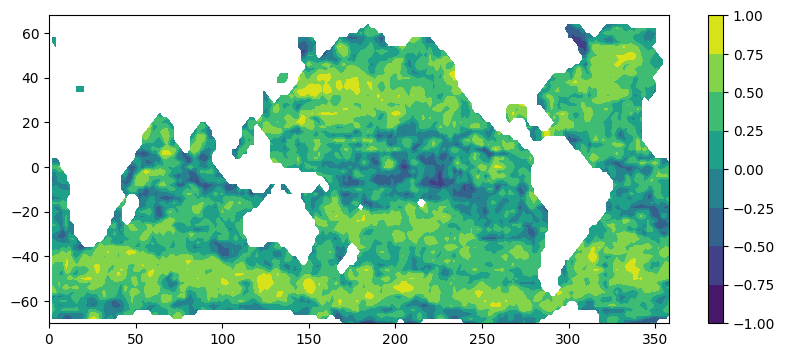

In [45]:
plt.figure(figsize=(10,4))
plt.contourf(lons, lats, coef)
plt.colorbar()

## Extra test code

In [ ]:
def testfunc(da)
    return

In [24]:
sla.rolling(dim={'Latitude':10, 'Longitude':10})

DataArrayRolling [Latitude->10,Longitude->10]

In [26]:
data = np.array(np.arange(6).reshape(2, 3),dtype="float64")
data

array([[0., 1., 2.],
       [3., 4., 5.]])

In [49]:
da =xr.DataArray(np.array(np.arange(6).reshape(2, 3),dtype="float64"),dims=("a","b"))

rolling = da.rolling({"a":3,"b":3}, center=True, min_periods=1)

# producing same results as in numpy example
da_roll = rolling.construct(a='ka',b='kb')
da_roll

<xarray.DataArray (a: 2, b: 3, ka: 3, kb: 3)>
array([[[[nan, nan, nan],
         [nan,  0.,  1.],
         [nan,  3.,  4.]],

        [[nan, nan, nan],
         [ 0.,  1.,  2.],
         [ 3.,  4.,  5.]],

        [[nan, nan, nan],
         [ 1.,  2., nan],
         [ 4.,  5., nan]]],


       [[[nan,  0.,  1.],
         [nan,  3.,  4.],
         [nan, nan, nan]],

        [[ 0.,  1.,  2.],
         [ 3.,  4.,  5.],
         [nan, nan, nan]],

        [[ 1.,  2., nan],
         [ 4.,  5., nan],
         [nan, nan, nan]]]])
Dimensions without coordinates: a, b, ka, kb

In [65]:
def testfunc(a, axis):
    return np.nanmean(a, axis=axis)

In [66]:
rolling.reduce(testfunc)

<xarray.DataArray (a: 2, b: 3)>
array([[2. , 2.5, 3. ],
       [2. , 2.5, 3. ]])
Dimensions without coordinates: a, b